In [ ]:
import numpy as np
import pickle
import cv2
import tensorflow
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
print("Drive mounting: ",end="")
drive.mount('/content/drive', force_remount=True)

import shutil
filename = "/content/drive/My Drive/labelled_images.zip"
extract_dir = "/content/main_input"
print(f'Unzipping file "{filename}" to "{extract_dir}"')
shutil.unpack_archive(filename, extract_dir)

Drive mounting: Mounted at /content/drive
Unzipping file "/content/drive/My Drive/labelled_images.zip" to "/content/main_input"


In [ ]:
# Values for the training the model

EPOCHS = 25 # default 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/main_input/labelled_images'
width=256
height=256
depth=3

# function for converting image to matrix of the pixel values
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        # plt.imshow(image)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Total dataset <br>
name                | no of images <br>
<p>-----------------------------</p>
Reduced mucosal view | 2906 <br>
Foreign body         | 776 <br>
Blood - hematin      | 12 <br>
Blood - fresh        | 446 <br>
Erosion              | 506 <br>
Ulcer                | 854 <br>
Ileocecal valve      | 4189 <br>
Lymphangiectasia     | 592 <br>
Pylorus              | 1529 <br>
Erythema             | 159 <br>
Angiectasia          | 866 <br>
Polyp                | 55 <br>
Normal clean mucosa  | 34338 <br>
Ampulla of vater     | 10

In [ ]:
image_list, label_list = [], []
try:

    print("Loading images ...")
    filter_count = input('Lower range of images per disease: ')
    images_count = input('How many images per disease: ')
    print('\nname     |    no of images')

    root_dir = listdir(directory_root)
    for folder in root_dir:
      label = listdir(f"{directory_root}/{folder}")
      image_directory = listdir(f"{directory_root}/{folder}/{label[0]}")
      print(label[0], len(image_directory))
      if len(image_directory)>=int(filter_count):
        for image in image_directory[:int(images_count)]:
          img_path = f"{directory_root}/{folder}/{label[0]}/{image}"
          image_list.append(convert_image_to_array(img_path))
          label_list.append(label[0])
except Exception as e:
    print(f"Error : {e}")

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(f"\nTotal images used {len(image_list)} from {n_classes} different diseases - {label_binarizer.classes_}")

Loading images ...
Lower range of images per disease: 1000
How many images per disease: 500

name     |    no of images
Lymphangiectasia 592
Erosion 506
Blood - fresh 446
Polyp 55
Blood - hematin 12
Erythema 159
Normal clean mucosa 34338
Foreign body 776
Reduced mucosal view 2906
Angiectasia 866
Ampulla of vater 10
Ileocecal valve 4189
Pylorus 1529
Ulcer 854

Total images used 2000 from 4 different diseases - ['Ileocecal valve' 'Normal clean mucosa' 'Pylorus' 'Reduced mucosal view']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print(len(np_image_list),'images normalized')
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.35, random_state = 42)
# k-fold cross validation here k=1 I think
# x_train means evidance or input and y_train means the labels or output
print("Spllited data to train, test :",len(x_train),len(x_test),len(y_train),len(y_test))

2000 images normalized
Spllited data to train, test : 1300 700 1300 700


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
# Support Vector Classifier [frpm sklearn.svm import SVC]
# Perceptron [from sklearn.linear_model import Perceptron]
# Gaussian [from sklearn.naive_bayes import GaussianNB]
# K neighbors [from sklearn.neighbors import KNeighborsClassifier] KNeighborsClassifier(n_neighbors=3)
# Default model Seuential
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

model.add(Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=inputShape))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Replace 'n_classes' with the number of output classes
model.add(Dense(n_classes, activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 batch_normalization_6 (Bat  (None, 256, 256, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_7 (Bat  (None, 128, 128, 64)     

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print("Training neural network...")
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Training neural network...
Epoch 1/25
40/40 [==============================] - 32s 675ms/step - loss: 0.7873 - accuracy: 0.5410 - val_loss: 0.9904 - val_accuracy: 0.2943
Epoch 2/25
40/40 [==============================] - 22s 559ms/step - loss: 0.5099 - accuracy: 0.6601 - val_loss: 1.4369 - val_accuracy: 0.2543
Epoch 3/25
40/40 [==============================] - 21s 525ms/step - loss: 0.3927 - accuracy: 0.7232 - val_loss: 0.8878 - val_accuracy: 0.2557
Epoch 4/25
40/40 [==============================] - 22s 558ms/step - loss: 0.3620 - accuracy: 0.7177 - val_loss: 0.6758 - val_accuracy: 0.2471
Epoch 5/25
40/40 [==============================] - 21s 521ms/step - loss: 0.3376 - accuracy: 0.7342 - val_loss: 0.7959 - val_accuracy: 0.3157
Epoch 6/25
40/40 [==============================] - 22s 553ms/step - loss: 0.3122 - accuracy: 0.7666 - val_loss: 0.8388 - val_accuracy: 0.3157
Epoch 7/25
40/40 [==============================] - 21s 529ms/step - loss: 0.3227 - accuracy: 0.7508 - val_loss: 1.

In [ ]:
# [ For checking only ]
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 25, 'steps': 40}
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


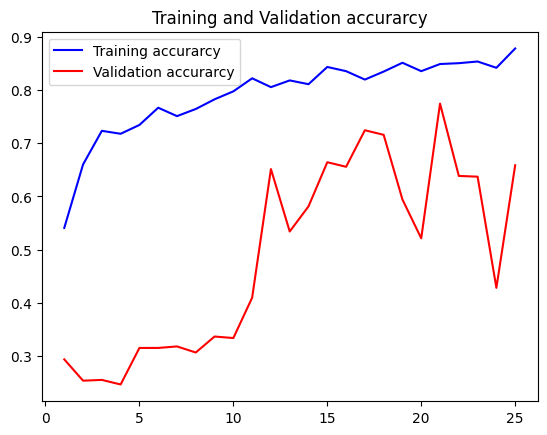

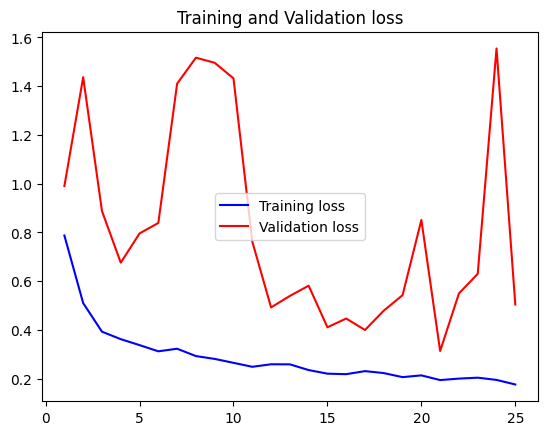

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
model.save("endoscopy.keras")
print('Model saved')
print("Calculating model accuracy:")
loaded_model = load_model("endoscopy.keras")
scores = loaded_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {round(scores[1]*100)}%")

Model saved
Calculating model accuracy:
22/22 [==============================] - 2s 33ms/step - loss: 0.5040 - accuracy: 0.6586
Test Accuracy: 66%


In [ ]:
image_location = f"/content/main_input/labelled_images/reduced_mucosal_view/Reduced mucosal view/8ebf0e483cac48d6_15375.jpg"
im=convert_image_to_array(image_location)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)
result = loaded_model.predict(npp_image)
print(result)
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

1/1 [==============================] - 1s 753ms/step
[[8.3510022e-06 3.1811255e-04 2.8580211e-03 2.2957191e-05 8.4039085e-02
  1.9869252e-05 8.7154651e-05 2.4789264e-02 8.8707161e-01 7.8556308e-04]]
probability:0.8870716
Reduced mucosal view
